# NFL Big Data Bowl 2023

## Data Exploration

### Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import re

### Read Data

In [2]:
games = pd.read_csv('./Resources/games.csv')
pff_scouting_data = pd.read_csv('./Resources/pffScoutingData.csv')
players = pd.read_csv('./Resources/players.csv')
plays = pd.read_csv('./Resources/plays.csv')

week_1 = pd.read_csv('./Resources/week1.csv')
week_2 = pd.read_csv('./Resources/week2.csv')
week_3 = pd.read_csv('./Resources/week3.csv')
week_4 = pd.read_csv('./Resources/week4.csv')
week_5 = pd.read_csv('./Resources/week5.csv')
week_6 = pd.read_csv('./Resources/week6.csv')
week_7 = pd.read_csv('./Resources/week7.csv')
week_8 = pd.read_csv('./Resources/week8.csv')

### View Data

#### Games

In [3]:
games.head()

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr
0,2021090900,2021,1,09/09/2021,20:20:00,TB,DAL
1,2021091200,2021,1,09/12/2021,13:00:00,ATL,PHI
2,2021091201,2021,1,09/12/2021,13:00:00,BUF,PIT
3,2021091202,2021,1,09/12/2021,13:00:00,CAR,NYJ
4,2021091203,2021,1,09/12/2021,13:00:00,CIN,MIN


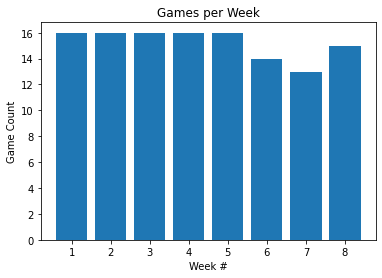

In [4]:
games_per_week = games[['week', 'gameId']] \
    .groupby('week') \
    .count() \
    .rename(columns={'gameId': 'gameCount'}, inplace=False) \
    .reset_index()

plt.bar(games_per_week['week'], games_per_week['gameCount'])
plt.xlabel('Week #')
plt.ylabel('Game Count')
plt.title('Games per Week')
plt.show()

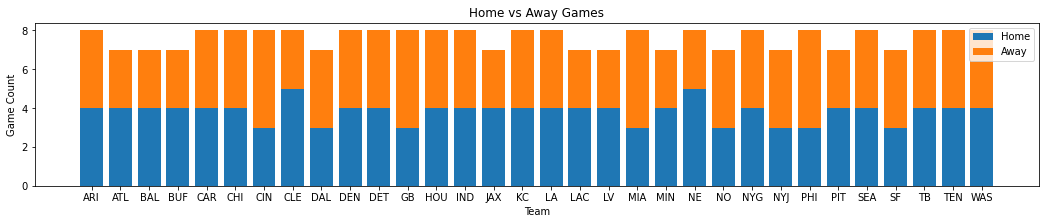

In [5]:
home_games_played = games[['homeTeamAbbr', 'gameId']] \
    .groupby('homeTeamAbbr') \
    .count() \
    .reset_index() \
    .rename(columns={
        'homeTeamAbbr': 'team',
        'gameId': 'home_games',
    }, inplace=False)

away_games_played = games[['visitorTeamAbbr', 'gameId']] \
    .groupby('visitorTeamAbbr') \
    .count() \
    .reset_index() \
    .rename(columns={
        'visitorTeamAbbr': 'team',
        'gameId': 'away_games',
    }, inplace=False)

games_played = pd.merge(home_games_played, away_games_played, on='team')
games_played

plt.figure(figsize=(18, 3))
plt.bar(games_played['team'], games_played['home_games'])
plt.bar(games_played['team'], games_played['away_games'], bottom=games_played['home_games'])
plt.xlabel('Team')
plt.ylabel('Game Count')
plt.title('Home vs Away Games')
plt.legend(["Home", "Away"])
plt.show()

#### PFF Scouting Data

In [6]:
pff_scouting_data.head()

,gameId,playId,nflId,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock
0,2021090900,97,25511,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021090900,97,35481,Pass Route,TE-L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021090900,97,35634,Pass Route,LWR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021090900,97,39985,Pass Route,HB-R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021090900,97,40151,Pass Block,C,NaN,NaN,NaN,0.0,0.0,0.0,0.0,44955.0,SW,0.0


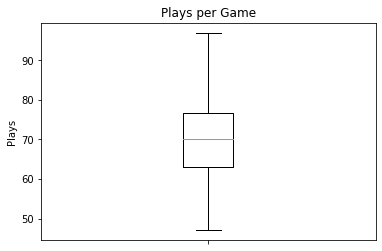

In [7]:
plays_per_game = pff_scouting_data[['gameId', 'playId']] \
    .groupby(['gameId', 'playId']) \
    .count() \
    .reset_index() \
    .groupby('gameId') \
    .count() \
    .reset_index() \
    .rename(columns={
        'playId': 'play_count',
    }, inplace=False)

fig, ax = plt.subplots()
ax.boxplot(plays_per_game['play_count'])
ax.set_ylabel('Plays')
ax.set_title('Plays per Game')
ax.set_xticks([1], [''])

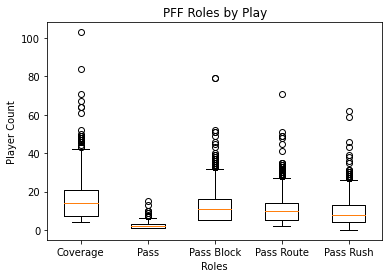

In [8]:
pff_roles_by_play = pd.pivot_table(
    pff_scouting_data,
    values='nflId',
    index='playId',
    columns='pff_role',
    aggfunc='count'
)

# One row with NaN in Pass Rush column found and replaced with 0
pff_roles_by_play[pff_roles_by_play.isna().any(axis=1)]
pff_roles_by_play = pff_roles_by_play.fillna(0)

fig, ax = plt.subplots()
ax.boxplot(pff_roles_by_play)
ax.set_ylabel('Player Count')
ax.set_xlabel('Roles')
ax.set_title('PFF Roles by Play')
ax.set_xticks(range(1,len(pff_roles_by_play.columns)+1), pff_roles_by_play.columns)
plt.show()

#### Players

In [9]:
players.head()

,nflId,height,weight,birthDate,collegeName,officialPosition,displayName
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,28963,6-5,240,1982-03-02,"Miami, O.",QB,Ben Roethlisberger
2,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters
3,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers
4,30078,6-2,228,1982-11-24,Harvard,QB,Ryan Fitzpatrick


In [10]:
players_cleaned = players.copy()
players_cleaned = players_cleaned.dropna()
players_cleaned['heightNumeric'] = players_cleaned['height'].apply(lambda x: int(x.split('-')[0]) + int(x.split("-")[1])/12)
players_cleaned['age'] = players_cleaned['birthDate'].apply(lambda x: 2021 - int(re.findall(r'\d{4}', str(x))[0]))
players_cleaned

,nflId,height,weight,birthDate,collegeName,officialPosition,displayName,heightNumeric,age
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady,6.333333,44
1,28963,6-5,240,1982-03-02,"Miami, O.",QB,Ben Roethlisberger,6.416667,39
2,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters,6.333333,39
3,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers,6.166667,38
4,30078,6-2,228,1982-11-24,Harvard,QB,Ryan Fitzpatrick,6.166667,39
...,...,...,...,...,...,...,...,...,...
1461,53074,6-3,215,1997-03-21,Indiana,WR,Nick Westbrook-Ikhine,6.250000,24
1462,53079,6-1,255,1997-08-20,Toledo,FB,Reggie Gilliam,6.083333,24
1463,53091,5-11,208,1996-05-17,Oregon State,RB,Artavis Pierce,5.916667,25
1464,53098,6-2,204,1998-03-27,Tennessee,WR,Marquez Callaway,6.166667,23


<AxesSubplot:title={'center':'heightNumeric'}, xlabel='[officialPosition]'>

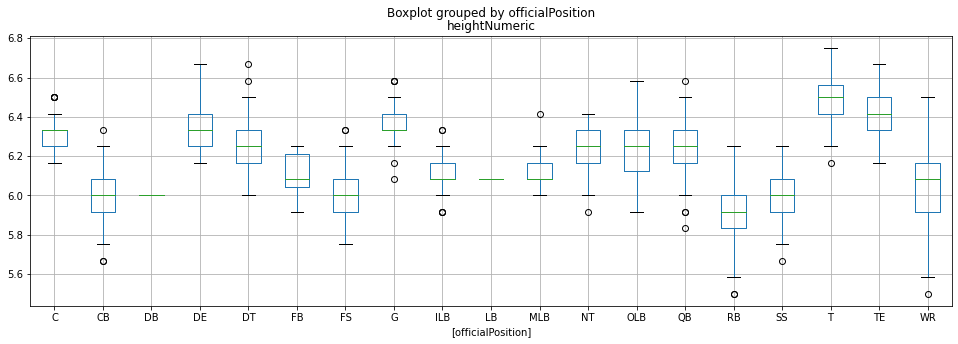

In [11]:
players_cleaned[['officialPosition', 'heightNumeric']] \
    .boxplot(['heightNumeric'], by=['officialPosition'], figsize=(16,5))

<AxesSubplot:title={'center':'weight'}, xlabel='[officialPosition]'>

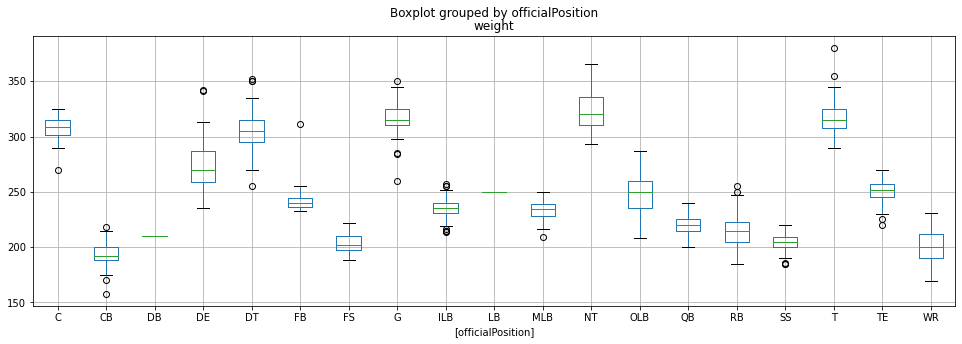

In [12]:
players_cleaned[['officialPosition', 'weight']] \
    .boxplot(['weight'], by=['officialPosition'], figsize=(16,5))

<AxesSubplot:title={'center':'age'}, xlabel='[officialPosition]'>

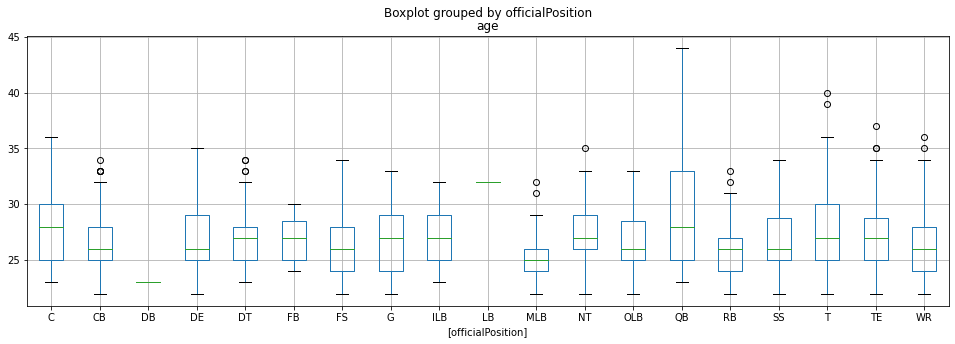

In [13]:
players_cleaned[['officialPosition', 'age']] \
    .boxplot(by=['officialPosition'], figsize=(16,5))

#### Plays

In [14]:
plays.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,foulNFLId3,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType
0,2021090900,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,...,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man
1,2021090900,137,(13:18) (Shotgun) D.Prescott pass deep left to...,1,1,10,DAL,TB,DAL,2,...,NaN,108.0,EMPTY,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 4 LB, 3 DB",TRADITIONAL,0,Cover-3,Zone
2,2021090900,187,(12:23) (Shotgun) D.Prescott pass short middle...,1,2,6,DAL,TB,DAL,34,...,NaN,76.0,SHOTGUN,"0 RB, 2 TE, 3 WR",6.0,"3 DL, 3 LB, 5 DB",TRADITIONAL,0,Cover-3,Zone
3,2021090900,282,(9:56) D.Prescott pass incomplete deep left to...,1,1,10,DAL,TB,TB,39,...,NaN,49.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB",TRADITIONAL,1,Cover-3,Zone
4,2021090900,349,(9:46) (Shotgun) D.Prescott pass incomplete sh...,1,3,15,DAL,TB,TB,44,...,NaN,54.0,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"3 DL, 4 LB, 4 DB",TRADITIONAL,0,Cover-3,Zone


#### Week 1

In [15]:
week_1.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100,12.0,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99,None
1,2021090900,97,25511.0,2,2021-09-10T00:26:31.200,12.0,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87,None
2,2021090900,97,25511.0,3,2021-09-10T00:26:31.300,12.0,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55,None
3,2021090900,97,25511.0,4,2021-09-10T00:26:31.400,12.0,TB,right,37.73,24.25,0.15,0.24,0.06,152.13,296.85,None
4,2021090900,97,25511.0,5,2021-09-10T00:26:31.500,12.0,TB,right,37.69,24.26,0.25,0.18,0.04,148.33,287.55,None


#### Week 2

In [16]:
week_2.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event
0,2021091600,65,40031.0,1,2021-09-17T00:23:09.600,23.0,NYG,right,46.32,22.36,0.93,0.83,0.09,271.71,79.32,None
1,2021091600,65,40031.0,2,2021-09-17T00:23:09.700,23.0,NYG,right,46.43,22.39,1.07,1.05,0.11,275.92,72.33,None
2,2021091600,65,40031.0,3,2021-09-17T00:23:09.800,23.0,NYG,right,46.54,22.44,1.21,1.11,0.12,278.85,67.03,None
3,2021091600,65,40031.0,4,2021-09-17T00:23:09.900,23.0,NYG,right,46.65,22.49,1.32,1.14,0.13,282.45,62.63,None
4,2021091600,65,40031.0,5,2021-09-17T00:23:10.000,23.0,NYG,right,46.77,22.56,1.49,1.42,0.14,285.54,59.26,None


#### Week 3

In [17]:
week_3.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event
0,2021092300,54,41300.0,1,2021-09-24T00:23:08.400,58.0,HOU,right,38.66,28.98,0.00,0.00,0.00,259.88,205.34,None
1,2021092300,54,41300.0,2,2021-09-24T00:23:08.500,58.0,HOU,right,38.66,28.98,0.00,0.00,0.01,259.88,197.10,None
2,2021092300,54,41300.0,3,2021-09-24T00:23:08.600,58.0,HOU,right,38.66,28.97,0.00,0.00,0.00,259.88,192.98,None
3,2021092300,54,41300.0,4,2021-09-24T00:23:08.700,58.0,HOU,right,38.66,28.97,0.02,0.34,0.00,259.88,181.68,None
4,2021092300,54,41300.0,5,2021-09-24T00:23:08.800,58.0,HOU,right,38.66,28.97,0.05,0.37,0.00,260.78,199.16,None


#### Week 4

In [18]:
week_4.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event
0,2021093000,169,38696.0,1,2021-10-01T00:29:42.800,11.0,JAX,right,54.66,44.66,0.0,0.0,0.0,107.61,134.74,None
1,2021093000,169,38696.0,2,2021-10-01T00:29:42.900,11.0,JAX,right,54.66,44.66,0.0,0.0,0.0,107.61,130.79,None
2,2021093000,169,38696.0,3,2021-10-01T00:29:43.000,11.0,JAX,right,54.66,44.67,0.0,0.0,0.0,107.61,122.78,None
3,2021093000,169,38696.0,4,2021-10-01T00:29:43.100,11.0,JAX,right,54.66,44.66,0.0,0.0,0.0,107.61,134.78,None
4,2021093000,169,38696.0,5,2021-10-01T00:29:43.200,11.0,JAX,right,54.66,44.66,0.0,0.0,0.0,107.61,130.76,None


#### Week 5

In [19]:
week_5.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event
0,2021100700,95,30869.0,1,2021-10-08T00:23:33.900,77.0,LA,right,22.93,33.04,0.02,0.02,0.00,102.26,129.51,None
1,2021100700,95,30869.0,2,2021-10-08T00:23:34.000,77.0,LA,right,22.93,33.04,0.01,0.02,0.00,101.64,128.68,None
2,2021100700,95,30869.0,3,2021-10-08T00:23:34.100,77.0,LA,right,22.92,33.05,0.01,0.01,0.01,100.73,127.26,None
3,2021100700,95,30869.0,4,2021-10-08T00:23:34.200,77.0,LA,right,22.92,33.05,0.01,0.01,0.01,100.73,130.90,None
4,2021100700,95,30869.0,5,2021-10-08T00:23:34.300,77.0,LA,right,22.91,33.05,0.01,0.01,0.01,99.55,134.16,None


#### Week 6

In [20]:
week_6.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event
0,2021101400,76,25511.0,1,2021-10-15T00:23:39.200,12.0,TB,right,33.99,23.88,0.0,0.0,0.00,91.73,67.89,None
1,2021101400,76,25511.0,2,2021-10-15T00:23:39.300,12.0,TB,right,33.99,23.88,0.0,0.0,0.00,91.73,57.67,None
2,2021101400,76,25511.0,3,2021-10-15T00:23:39.400,12.0,TB,right,34.00,23.89,0.0,0.0,0.01,91.73,49.03,None
3,2021101400,76,25511.0,4,2021-10-15T00:23:39.500,12.0,TB,right,34.00,23.89,0.0,0.0,0.00,91.73,47.57,None
4,2021101400,76,25511.0,5,2021-10-15T00:23:39.600,12.0,TB,right,34.00,23.89,0.0,0.0,0.00,91.73,50.68,None


#### Week 7

In [21]:
week_7.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event
0,2021102100,56,35459.0,1,2021-10-22T00:23:17.300,22.0,DEN,left,75.42,20.77,0.97,1.03,0.09,60.75,64.69,None
1,2021102100,56,35459.0,2,2021-10-22T00:23:17.400,22.0,DEN,left,75.51,20.82,1.09,0.97,0.11,63.06,60.90,None
2,2021102100,56,35459.0,3,2021-10-22T00:23:17.500,22.0,DEN,left,75.61,20.88,1.23,0.79,0.12,63.06,61.13,None
3,2021102100,56,35459.0,4,2021-10-22T00:23:17.600,22.0,DEN,left,75.73,20.94,1.30,0.57,0.13,62.35,60.85,None
4,2021102100,56,35459.0,5,2021-10-22T00:23:17.700,22.0,DEN,left,75.84,21.01,1.33,0.37,0.13,60.65,60.99,None


#### Week 8

In [22]:
week_8.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event
0,2021102800,189,37077.0,1,2021-10-29T00:27:23.000,18.0,ARI,right,21.38,6.94,0.0,0.0,0.00,43.74,223.19,None
1,2021102800,189,37077.0,2,2021-10-29T00:27:23.100,18.0,ARI,right,21.38,6.94,0.0,0.0,0.00,44.67,243.81,None
2,2021102800,189,37077.0,3,2021-10-29T00:27:23.200,18.0,ARI,right,21.38,6.95,0.0,0.0,0.00,45.69,303.24,None
3,2021102800,189,37077.0,4,2021-10-29T00:27:23.300,18.0,ARI,right,21.38,6.94,0.0,0.0,0.00,46.44,285.89,None
4,2021102800,189,37077.0,5,2021-10-29T00:27:23.400,18.0,ARI,right,21.38,6.95,0.0,0.0,0.01,47.99,341.60,None


In [23]:
# Concatenate week DataFrames
week_1_append = week_1.copy()
week_1_append['week'] = 1

week_2_append = week_2.copy()
week_2_append['week'] = 2

week_3_append = week_3.copy()
week_3_append['week'] = 3

week_4_append = week_4.copy()
week_4_append['week'] = 4

week_5_append = week_5.copy()
week_5_append['week'] = 5

week_6_append = week_6.copy()
week_6_append['week'] = 6

week_7_append = week_7.copy()
week_7_append['week'] = 7

week_8_append = week_8.copy()
week_8_append['week'] = 8

week_concat = pd.concat(
    [
        week_1_append,
        week_2_append,
        week_3_append,
        week_4_append,
        week_5_append,
        week_6_append,
        week_7_append,
        week_8_append
    ],
    ignore_index=True
)

week_concat

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event,week
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100,12.0,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99,None,1
1,2021090900,97,25511.0,2,2021-09-10T00:26:31.200,12.0,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87,None,1
2,2021090900,97,25511.0,3,2021-09-10T00:26:31.300,12.0,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55,None,1
3,2021090900,97,25511.0,4,2021-09-10T00:26:31.400,12.0,TB,right,37.73,24.25,0.15,0.24,0.06,152.13,296.85,None,1
4,2021090900,97,25511.0,5,2021-09-10T00:26:31.500,12.0,TB,right,37.69,24.26,0.25,0.18,0.04,148.33,287.55,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8314173,2021110100,4433,NaN,54,2021-11-02T03:20:26.500,NaN,football,right,24.17,27.89,2.47,2.28,0.25,NaN,NaN,None,8
8314174,2021110100,4433,NaN,55,2021-11-02T03:20:26.600,NaN,football,right,24.36,28.03,2.36,2.16,0.24,NaN,NaN,None,8
8314175,2021110100,4433,NaN,56,2021-11-02T03:20:26.700,NaN,football,right,24.55,28.17,2.25,1.45,0.23,NaN,NaN,None,8
8314176,2021110100,4433,NaN,57,2021-11-02T03:20:26.800,NaN,football,right,24.73,28.31,2.28,0.72,0.23,NaN,NaN,None,8


In [30]:
week_concat.info(verbose=True, null_counts=True)

C:\Users\lself\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8314178 entries, 0 to 8314177
Data columns (total 18 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   gameId         8314178 non-null  int64  
 1   playId         8314178 non-null  int64  
 2   nflId          7952692 non-null  float64
 3   frameId        8314178 non-null  int64  
 4   time           8314178 non-null  object 
 5   jerseyNumber   7952692 non-null  float64
 6   team           8314178 non-null  object 
 7   playDirection  8314178 non-null  object 
 8   x              8314178 non-null  float64
 9   y              8314178 non-null  float64
 10  s              8314178 non-null  float64
 11  a              8314178 non-null  float64
 12  dis            8314178 non-null  float64
 13  o              7952692 non-null  float64
 14  dir            7952692 non-null  float64
 15  event          8314178 non-null  object 
 16  week           8314178 non-null  int64  
 17  sack    